## v3

In [1]:
import pandas as pd
fluency = pd.read_csv('llama/whisper-v3-llama-response-fluency.csv').drop([36]).reset_index()
richness = pd.read_csv('llama/whisper-v3-llama-response-richness.csv').drop([36]).reset_index()
correlation = pd.read_csv('llama/whisper-v3-llama-response-correlation.csv').drop([36]).reset_index()
grammar = pd.read_csv('llama/whisper-v3-llama-response-grammar.csv').drop([36]).reset_index()
cdrsob = pd.read_csv('data/CDRSOB1.txt', sep=" ")
# repeatability = pd.read_csv('llama/whisper-v3-llama-response-repeatability.csv')
# combine = pd.concat([fluency["file"], cdrsob["CDRSOB"], fluency["eval"], richness["eval"], correlation["eval"], grammar["eval"]], repeatability["eval"], axis=1,
#           keys=['file', 'CDRSOB', 'fluency', 'richness', 'correlation', 'grammar', 'repeatability'])
combine = pd.concat([fluency["file"], fluency["AD"], cdrsob["CDRSOB"], fluency["eval"], richness["eval"], correlation["eval"], grammar["eval"]], axis=1,
          keys=['file', 'AD', 'CDRSOB', 'fluency', 'richness', 'correlation', 'grammar'])
combine.to_csv("llama/whisper-v3-llama-cdrsob.csv", index=False)
# combine = combine.dropna()
combine

,file,AD,CDRSOB,fluency,richness,correlation,grammar
0,1,0,0.0,3.5,3.5,3.5,3.5
1,2,0,0.0,3.5,3.5,3.5,2.5
2,3,0,0.0,3.5,3.5,3.5,3.5
3,4,1,1.5,2.5,2.5,2.5,2.5
4,5,1,1.0,3.0,2.5,2.5,3.0
...,...,...,...,...,...,...,...
82,96,0,0.0,2.5,3.0,3.5,2.0
83,97,0,0.0,3.5,3.5,3.5,3.5
84,98,0,0.0,3.5,3.5,3.5,3.5
85,99,0,0.0,3.5,3.5,3.5,3.5


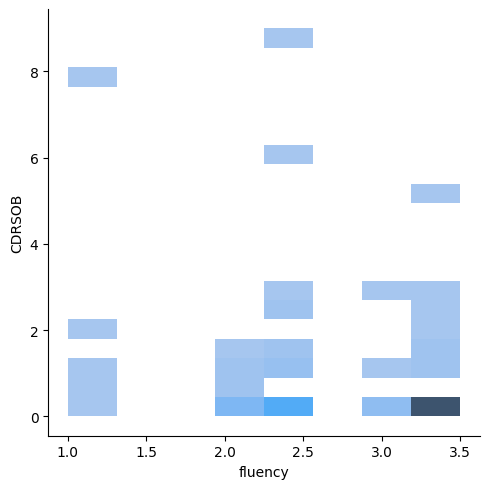

In [2]:
import seaborn as sns
sns.displot(combine, x="fluency", y="CDRSOB")

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
# os.environ['CUDA_VISIBLE_DEVICES']='0,1'
os.environ['CUDA_LAUNCH_BLOCKING']='1'
import torch
# torch.cuda.set_device(0)
print(torch.cuda.current_device())
#! python
# -*- coding: utf-8 -*-
# Author: kun
# @Time: 2019-10-29 20:29

import yaml
import argparse
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

class Para(object):
    a=1

def list_5fold():
    path_list = []
    for idx in range(5):
        path = "data_process/CTT5-" + str(idx+1) + "-2"
        for f in os.listdir(path):
            file = int(str(f).split("CTT")[0].split('/')[-1])
            path_list.append({"file": file, "5fold": idx+1})
    return path_list

def main():
    # For reproducibility, comment these may speed up training
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print("start")
    
    path_list = pd.DataFrame(list_5fold())
    path_list = path_list.sort_values(by='file', ascending=True)
    # path_list.set_index("file" , inplace=True)
    path_list = path_list.reset_index()
    # print(path_list)

    response = pd.read_csv('llama/whisper-v3-llama-cdrsob.csv')
    # response = response.replace({'eval': {-1: 1}})
    # print(response)
    response["5fold"] = path_list["5fold"]

    feature = response.drop(columns = ['file', 'CDRSOB', 'AD']).astype(np.int64).to_numpy()
    # feature = response["eval"].to_numpy()
    # feature = np.reshape(feature, (-1, 1))

    target = response["CDRSOB"].to_numpy()
    target = np.reshape(target, (-1, 1))

    # print(feature, target)
    
    alldf =pd.DataFrame()
    for fold in range(0,5):
        # 5 fold
        train = []
        valid = []
        t_tra = []
        t_val = []
        name = []
        ad = []
        # y_predicted_val = []
        idx = 0

        for idx in range(feature.shape[0]):
            if(int(response["5fold"][idx]) != int(str(fold+1))):
                train.append(feature[idx])
                t_tra.append(target[idx])
            else:
                valid.append(feature[idx])
                t_val.append(target[idx])
                # if(feature[idx]>=5):
                #     y_predicted_val.append(0)
                # else:
                #     y_predicted_val.append(1)                    
                name.append(response["file"][idx])
                ad.append(response["AD"][idx])

        train = np.array(train)
        t_tra = np.array(t_tra)
        valid = np.array(valid)
        t_val = np.array(t_val)
        name = np.array(name)
        # name = np.reshape(name, (-1, 1)) 
        
        print("fold: ", fold)
        
        # clf = SVR(kernel='linear')
        clf = make_pipeline(StandardScaler(), SVR(kernel='linear'))

        # Fit the model to the data
        clf.fit(train, t_tra.ravel())
        # print(train, t_tra)
#         print(reg.coef_)
        y_predicted = clf.predict(train)
#         loss = mean_squared_error(t_tra, y_predicted)
        y_predicted_val = clf.predict(valid)
        # y_predicted_val = np.reshape(y_predicted_val, (-1, 1)) 
#         loss_val = mean_squared_error(t_val, y_predicted_val)
#         print("loss ", loss, "loss_val", loss_val)

        
        # pipeline = Pipeline([
        #     ('scaler', StandardScaler()), 
        #     ('svc', SVR())
        # ])

        # param_grid = {
        #     'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        #     'svc__C': [0.1, 1, 10, 100],
        #     'svc__gamma': ['scale', 'auto'], 
        #     'svc__degree': [2, 3, 4] 
        # }

        # grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)
        # grid_search.fit(train, t_tra.ravel())

        # print("Best Parameters: ", grid_search.best_params_)
        # best_clf = grid_search.best_estimator_
        # y_predicted_val = best_clf.predict(valid)

        train = np.reshape(train, (-1,))
        t_tra = np.reshape(t_tra, (-1,))
        valid = np.reshape(valid, (-1,))
        t_val = np.reshape(t_val, (-1,))

        # print('train:', train)
        # print(t_tra)
        # print("valid", valid)
        # print(y_predicted_val)

        # plt.scatter(train, t_tra, cmap=plt.cm.coolwarm)
        # plt.xlabel('Sepal length')
        # plt.ylabel('Sepal width')
        # plt.xticks(())
        # plt.yticks(())
        # plt.show()
        
        # print(name, y_predicted_val, t_val)
        df = pd.DataFrame(
            {'name': name,
             'hyps': y_predicted_val,
             'truth': t_val,
             'ad': ad,
            #  'eval': valid
            })
        alldf = pd.concat([alldf, df])#
#         print(df)
        # df.to_csv(f'biclass_result/5folds_biclass_{fold+1}_pause_e.csv', index=False)
    alldf.to_csv("CDRSOB_result/llama-v3.csv", index=False) 
    return True


0


In [4]:
main()

start
fold:  0
fold:  1
fold:  2
fold:  3
fold:  4


True

In [5]:
llama_v3 = pd.read_csv('CDRSOB_result/llama-v3.csv')
# fivefolds_1k['result'] = np.where(fivefolds_1k['hyps'] >= 0.5,1,0)
# llama_v3.head(50)
llama_v3

,name,hyps,truth,ad
0,15,0.097546,0.0,0
1,16,0.897133,3.0,1
2,19,0.897133,2.5,0
3,22,0.897133,0.0,0
4,28,0.897133,0.5,1
...,...,...,...,...
82,73,0.166032,0.0,0
83,74,0.166032,0.0,0
84,80,0.299723,0.0,0
85,91,0.166032,0.0,0


In [6]:
# fivefolds_1_result = fivefolds_1k['result'].tolist()
# fivefolds_1_truth = [int(i) for i in fivefolds_1k['truth'].tolist()]
from sklearn import metrics

llama_v3_hyps = llama_v3['hyps'].tolist()
llama_v3_truth = llama_v3['truth'].tolist()

llama_v3_wrong = llama_v3.iloc[np.where(llama_v3['hyps'] != llama_v3['truth'])]
print(llama_v3_wrong)

# target_names = ['non-patient', 'patient']
# clf_report = metrics.classification_report(llama_v3_truth, llama_v3_hyps, target_names=target_names)
# print(clf_report)

# tn, fp, fn, tp = metrics.confusion_matrix(llama_v3_truth, llama_v3_hyps).ravel()
# print('sensitivuty: ',tp / (fn+tp))
# print('specificity: ',tn / (fp+tn))

# fpr, tpr, thresholds = metrics.roc_curve(np.array(llama_v3_truth), np.array(llama_v3_hyps), pos_label=1)
# print('AUC: ',metrics.auc(fpr, tpr))
# fpr1, tpr1, thresholds1 = metrics.roc_curve(np.array(llama_v3_truth[0:19]), np.array(llama_v3_hyps[0:19]), pos_label=1)
# auc1 = metrics.auc(fpr1, tpr1)
# fpr2, tpr2, thresholds2 = metrics.roc_curve(np.array(llama_v3_truth[37:54]), np.array(llama_v3_hyps[37:54]), pos_label=1)
# auc2 = metrics.auc(fpr2, tpr2)
# fpr3, tpr3, thresholds3 = metrics.roc_curve(np.array(llama_v3_truth[37:54]), np.array(llama_v3_hyps[37:54]), pos_label=1)
# auc3 = metrics.auc(fpr3, tpr3)
# fpr4, tpr4, thresholds4 = metrics.roc_curve(np.array(llama_v3_truth[37:54]), np.array(llama_v3_hyps[37:54]), pos_label=1)
# auc4 = metrics.auc(fpr4, tpr4)
# fpr5, tpr5, thresholds5 = metrics.roc_curve(np.array(llama_v3_truth[37:54]), np.array(llama_v3_hyps[37:54]), pos_label=1)
# auc5 = metrics.auc(fpr5, tpr5)
# print('AUC: ', auc1, auc2, auc3, auc4, auc5)
# print("AUC_avg: ", (auc1+auc2+auc3+auc4+auc5)/5)

# y_test = [bool(int(x)) for x in llama_v3_truth]
# y_pred = [bool(int(x)) for x in llama_v3_hyps]
# metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")

    name      hyps  truth  ad
0     15  0.097546    0.0   0
1     16  0.897133    3.0   1
2     19  0.897133    2.5   0
3     22  0.897133    0.0   0
4     28  0.897133    0.5   1
..   ...       ...    ...  ..
82    73  0.166032    0.0   0
83    74  0.166032    0.0   0
84    80  0.299723    0.0   0
85    91  0.166032    0.0   0
86    96  0.166110    0.0   0

[87 rows x 4 columns]


## v2

In [1]:
import pandas as pd
# fluency = pd.read_csv('llama/diarization_overlap/whisper-v2-llama-response-fluency.csv').drop([36]).reset_index()
# richness = pd.read_csv('llama/diarization_overlap/whisper-v2-llama-response-richness.csv').drop([36]).reset_index()
# correlation = pd.read_csv('llama/diarization_overlap/whisper-v2-llama-response-correlation.csv').drop([36]).reset_index()
# grammar = pd.read_csv('llama/diarization_overlap/whisper-v2-llama-response-grammar.csv').drop([36]).reset_index()
# complexity = pd.read_csv('llama/diarization_overlap/whisper-v2-llama-response-complexity.csv').drop([36]).reset_index()
fluency = pd.read_csv('chatgpt/remove/whisper-v2-gpt-response-fluency.csv').drop([36]).reset_index()
richness = pd.read_csv('chatgpt/remove/whisper-v2-gpt-response-richness.csv').drop([36]).reset_index()
correlation = pd.read_csv('chatgpt/remove/whisper-v2-gpt-response-correlation.csv').drop([36]).reset_index()
grammar = pd.read_csv('chatgpt/remove/whisper-v2-gpt-response-grammar.csv').drop([36]).reset_index()
complexity = pd.read_csv('chatgpt/remove/whisper-v2-gpt-response-complexity.csv').drop([36]).reset_index()
cdrsob = pd.read_csv('data/CDRSOB.txt', sep=" ")
# repeatability = pd.read_csv('llama/whisper-v2-llama-response-repeatability.csv')
# combine = pd.concat([fluency["file"], cdrsob["CDRSOB"], fluency["eval"], richness["eval"], correlation["eval"], grammar["eval"]], repeatability["eval"], axis=1,
#           keys=['file', 'CDRSOB', 'fluency', 'richness', 'correlation', 'grammar', 'repeatability'])
combine = pd.concat([fluency["file"], fluency["AD"], cdrsob["CDRSOB"], fluency["eval"], richness["eval"], correlation["eval"], grammar["eval"], complexity["eval"]], axis=1,
          keys=['file', 'AD', 'CDRSOB', 'fluency', 'richness', 'correlation', 'grammar', 'complexity'])
combine.to_csv("llama/whisper-v2-llama-cdrsob.csv", index=False)
combine.to_csv("chatgpt/remove/whisper-v2-chatgpt-cdrsob.csv", index=False)
# combine = combine.dropna()
combine

,file,AD,CDRSOB,fluency,richness,correlation,grammar,complexity
0,1,0,0.0,6,7,7,6,4
1,2,0,0.0,6,6,7,6,3
2,3,0,0.0,6,6,6,6,3
3,4,1,1.5,3,4,6,3,3
4,5,1,1.0,6,6,6,6,5
...,...,...,...,...,...,...,...,...
80,96,0,0.0,6,6,7,6,5
81,97,0,0.0,6,6,7,7,6
82,98,0,0.0,7,6,7,6,4
83,99,0,0.0,6,6,7,6,4


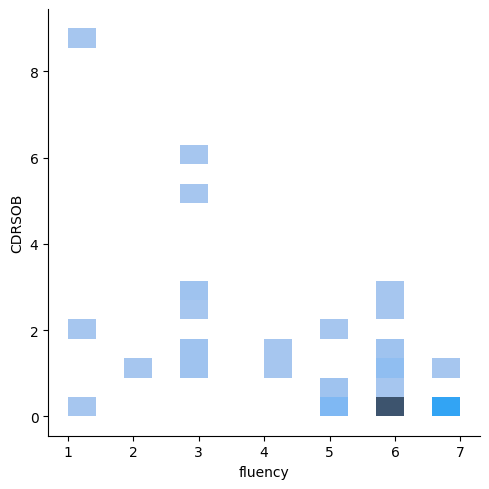

In [2]:
import seaborn as sns
sns.displot(combine, x="fluency", y="CDRSOB")

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
# os.environ['CUDA_VISIBLE_DEVICES']='0,1'
os.environ['CUDA_LAUNCH_BLOCKING']='1'
import torch
# torch.cuda.set_device(0)
print(torch.cuda.current_device())
#! python
# -*- coding: utf-8 -*-
# Author: kun
# @Time: 2019-10-29 20:29

import yaml
import argparse
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

class Para(object):
    a=1

def list_5fold():
    path_list = []
    for idx in range(5):
        path = "data_process/CTT5-" + str(idx+1) + "-2"
        for f in os.listdir(path):
            file = int(str(f).split("CTT")[0].split('/')[-1])
            path_list.append({"file": file, "5fold": idx+1})
    return path_list

def main():
    # For reproducibility, comment these may speed up training
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print("start")
    
    path_list = pd.DataFrame(list_5fold())
    path_list = path_list.sort_values(by='file', ascending=True)
    # path_list.set_index("file" , inplace=True)
    path_list = path_list.reset_index()
    # print(path_list)

    response = pd.read_csv('chatgpt/remove/whisper-v2-chatgpt-cdrsob.csv')
    # response = response.replace({'eval': {-1: 1}})
    # print(response)
    response["5fold"] = path_list["5fold"]

    feature = response.drop(columns = ['file', 'CDRSOB', 'AD']).astype(np.int64).to_numpy()
    # feature = response["eval"].to_numpy()
    # feature = np.reshape(feature, (-1, 1))

    target = response["CDRSOB"].to_numpy()
    target = np.reshape(target, (-1, 1))

    # print(feature, target)
    
    alldf =pd.DataFrame()
    for fold in range(0,5):
        # 5 fold
        train = []
        valid = []
        t_tra = []
        t_val = []
        name = []
        ad = []
        # y_predicted_val = []
        idx = 0

        for idx in range(feature.shape[0]):
            if(int(response["5fold"][idx]) != int(str(fold+1))):
                train.append(feature[idx])
                t_tra.append(target[idx])
            else:
                valid.append(feature[idx])
                t_val.append(target[idx])
                # if(feature[idx]>=5):
                #     y_predicted_val.append(0)
                # else:
                #     y_predicted_val.append(1)                    
                name.append(response["file"][idx])
                ad.append(response["AD"][idx])

        train = np.array(train)
        t_tra = np.array(t_tra)
        valid = np.array(valid)
        t_val = np.array(t_val)
        name = np.array(name)
        # name = np.reshape(name, (-1, 1)) 
        
        print("fold: ", fold)
        
        # clf = SVR(kernel='linear')
        clf = make_pipeline(StandardScaler(), SVR(kernel='linear'))

        # Fit the model to the data
        clf.fit(train, t_tra.ravel())
        # print(train, t_tra)
#         print(reg.coef_)
        y_predicted = clf.predict(train)
#         loss = mean_squared_error(t_tra, y_predicted)
        y_predicted_val = clf.predict(valid)
        # y_predicted_val = np.reshape(y_predicted_val, (-1, 1)) 
#         loss_val = mean_squared_error(t_val, y_predicted_val)
#         print("loss ", loss, "loss_val", loss_val)

        
        # pipeline = Pipeline([
        #     ('scaler', StandardScaler()), 
        #     ('svc', SVR())
        # ])

        # param_grid = {
        #     'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        #     'svc__C': [0.1, 1, 10, 100],
        #     'svc__gamma': ['scale', 'auto'], 
        #     'svc__degree': [2, 3, 4] 
        # }

        # grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)
        # grid_search.fit(train, t_tra.ravel())

        # print("Best Parameters: ", grid_search.best_params_)
        # best_clf = grid_search.best_estimator_
        # y_predicted_val = best_clf.predict(valid)

        train = np.reshape(train, (-1,))
        t_tra = np.reshape(t_tra, (-1,))
        valid = np.reshape(valid, (-1,))
        t_val = np.reshape(t_val, (-1,))

        # print('train:', train)
        # print(t_tra)
        # print("valid", valid)
        # print(y_predicted_val)

        # plt.scatter(train, t_tra, cmap=plt.cm.coolwarm)
        # plt.xlabel('Sepal length')
        # plt.ylabel('Sepal width')
        # plt.xticks(())
        # plt.yticks(())
        # plt.show()
        
        # print(name, y_predicted_val, t_val)
        df = pd.DataFrame(
            {'name': name,
             'hyps': y_predicted_val,
             'truth': t_val,
             'ad': ad,
            #  'eval': valid
            })
        alldf = pd.concat([alldf, df])#
#         print(df)
        # df.to_csv(f'biclass_result/5folds_biclass_{fold+1}_pause_e.csv', index=False)
    alldf.to_csv("CDRSOB_result/gpt-v2-r-final.csv", index=False) 
    return True


0


In [4]:
main()

start
fold:  0
fold:  1
fold:  2
fold:  3
fold:  4


True

In [5]:
llama_v2 = pd.read_csv('CDRSOB_result/gpt-v2-r-final.csv')
# fivefolds_1k['result'] = np.where(fivefolds_1k['hyps'] >= 0.5,1,0)
# llama_v2.head(50)
llama_v2

,name,hyps,truth,ad
0,15,0.099533,0.0,0
1,16,1.214246,3.0,1
2,22,0.099533,0.0,0
3,28,0.214383,0.5,1
4,34,0.156832,0.0,0
...,...,...,...,...
80,73,0.405723,0.0,0
81,74,0.795729,0.0,0
82,80,0.086618,0.0,0
83,91,-0.106381,0.0,0


In [6]:
from sklearn import metrics

llama_v2['ad'] =  llama_v2['ad'].replace(0, 'Non-Dementia')
llama_v2['ad'] =  llama_v2['ad'].replace(1, 'Dementia')
llama_v2_hyps = llama_v2['hyps'].tolist()
llama_v2_truth = llama_v2['truth'].tolist()

llama_v2_wrong = llama_v2.iloc[np.where(llama_v2['hyps'] != llama_v2['truth'])]
print(llama_v2_wrong)

llama_v2_label = llama_v2['ad'].tolist()
llama_v2_hyps = [float(i) for i in llama_v2['hyps'].tolist()]
llama_v2_truth = [float(i) for i in llama_v2['truth'].tolist()]
llama_v2_name = [str(i).replace("CTT", "") for i in llama_v2['name'].tolist()]

print('evs: ', metrics.explained_variance_score(llama_v2_truth, llama_v2_hyps))
print('mae: ', metrics.mean_absolute_error(llama_v2_truth, llama_v2_hyps))
print('mse: ', metrics.mean_squared_error(llama_v2_truth, llama_v2_hyps))
print('rmse: ', np.sqrt(metrics.mean_squared_error(llama_v2_truth, llama_v2_hyps)))
print('r2: ', metrics.r2_score(llama_v2_truth, llama_v2_hyps))
total_mae = metrics.mean_absolute_error(llama_v2_truth, llama_v2_hyps)

    name      hyps  truth            ad
0     15  0.099533    0.0  Non-Dementia
1     16  1.214246    3.0      Dementia
2     22  0.099533    0.0  Non-Dementia
3     28  0.214383    0.5      Dementia
4     34  0.156832    0.0  Non-Dementia
..   ...       ...    ...           ...
80    73  0.405723    0.0  Non-Dementia
81    74  0.795729    0.0  Non-Dementia
82    80  0.086618    0.0  Non-Dementia
83    91 -0.106381    0.0  Non-Dementia
84    96  0.086618    0.0  Non-Dementia

[85 rows x 4 columns]
evs:  0.30898147967699274
mae:  0.6032013333780124
mse:  1.5048402280117612
rmse:  1.2267192947091692
r2:  0.26320803392505165


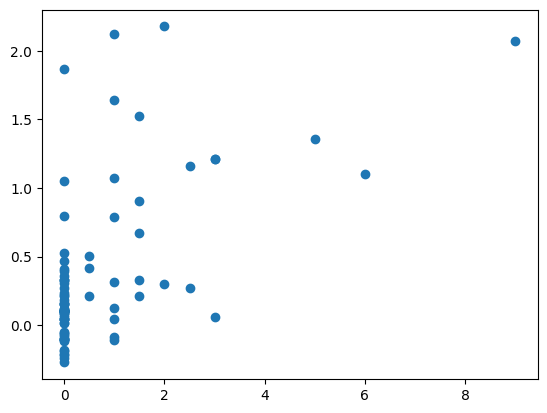

In [7]:
import matplotlib.pyplot as plt
plt.scatter(llama_v2_truth, llama_v2_hyps)
# plt.plot(list(range(len(fivefolds_1_truth))), fivefolds_1_hyps)
plt.show()

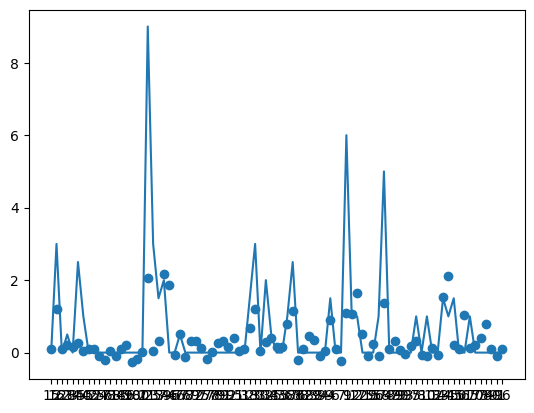

In [8]:
import matplotlib.pyplot as plt
plt.scatter(llama_v2_name, llama_v2_hyps)
plt.plot(llama_v2_name, llama_v2_truth)
plt.show()

<Axes: >

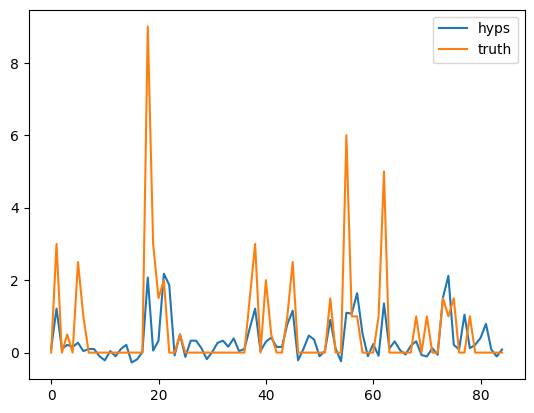

In [9]:
llama_v2_noname = llama_v2
llama_v2_noname = llama_v2_noname.drop(['name'], axis=1)
llama_v2_noname.plot()

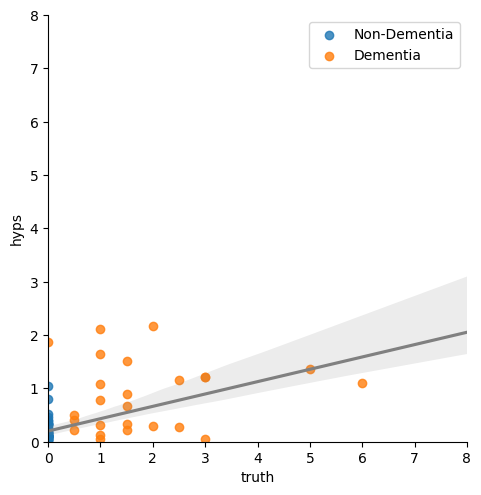

In [10]:
import seaborn as sns
from scipy import stats

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(llama_v2['truth'],llama_v2['hyps'])

# Use lmplot to plot scatter points
sns.lmplot(x='truth', y='hyps', hue='ad', data=llama_v2, fit_reg=False, legend=False)

# Use regplot to plot the regression line and use line_kws to set line label for legend
# ax = sns.regplot(x="truth", y="hyps", data=fivefolds_14k, scatter_kws={"zorder":-1},
# line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept), "color": "green"})
ax = sns.regplot(x="truth", y="hyps", data=llama_v2, scatter_kws={"zorder":-1, "color": "white"}, line_kws={"color": "gray"})

# plot legend
ax.legend()
ax.set_xlim(0, 8)
ax.set_ylim(0, 8)

# save the plot as PNG file
plt.savefig("CDRSOB_result/CDRSOB_v2_llama.png")
plt.savefig("CDRSOB_result/CDRSOB_v2_llama.jpg")

<Axes: xlabel='truth', ylabel='hyps'>

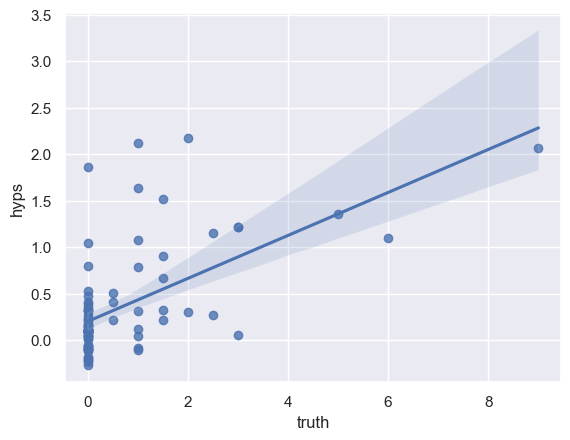

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(color_codes=True)
tips = sns.load_dataset("tips")
sns.regplot(x="truth", y="hyps", data=llama_v2)

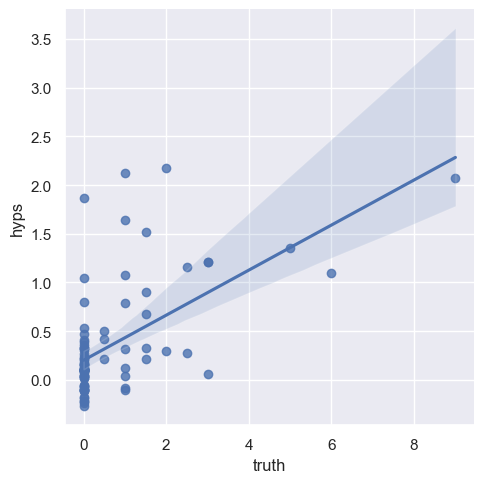

In [12]:
sns.lmplot(x="truth", y="hyps", data=llama_v2)

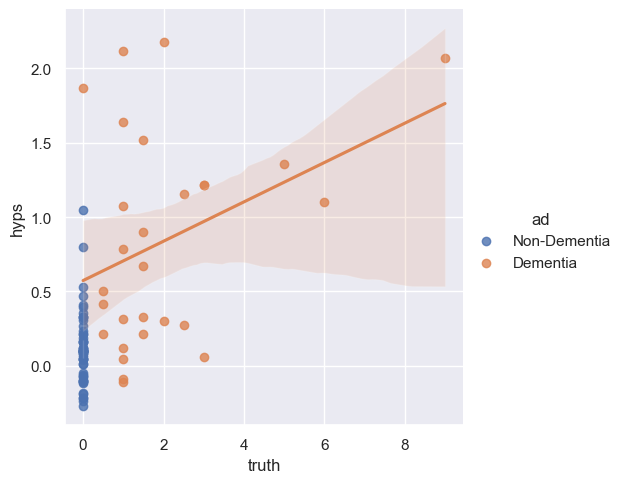

In [13]:
sns.lmplot(x="truth", y="hyps", hue="ad", data=llama_v2)

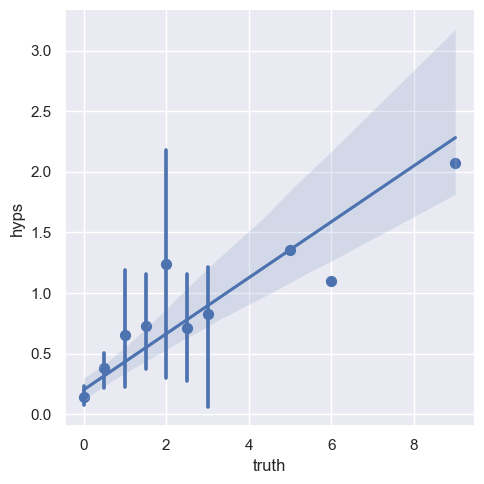

In [14]:
sns.lmplot(x="truth", y="hyps", data=llama_v2, x_estimator=np.mean);

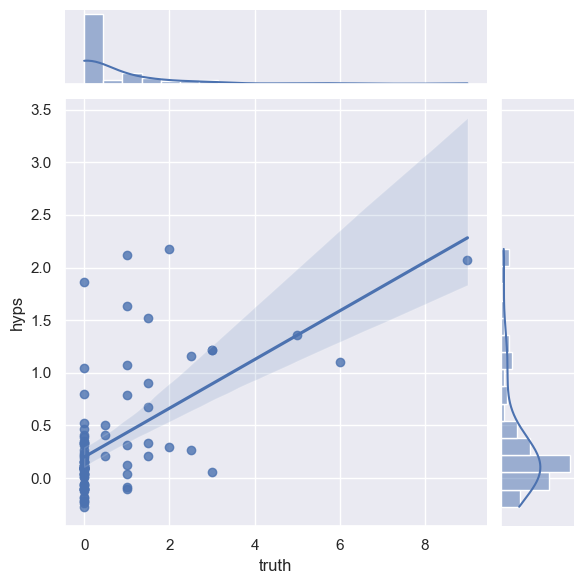

In [15]:
sns.jointplot(x="truth", y="hyps", data=llama_v2, kind="reg")

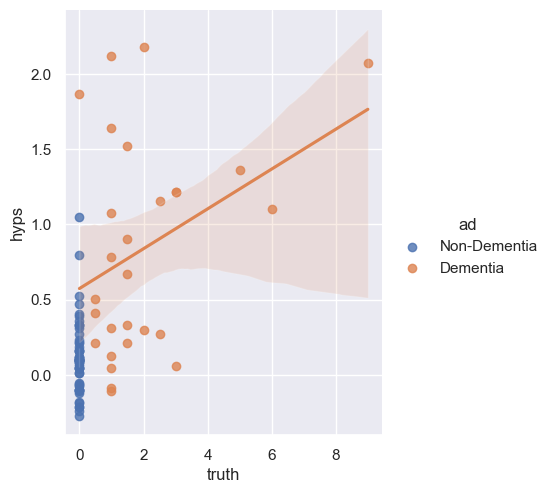

In [16]:
sns.pairplot(llama_v2, x_vars="truth", y_vars="hyps", hue="ad", height=5, aspect=.8, kind="reg")